# Tutorial: Discover relationships in a Power BI dataset using Semantic Link
This tutorial illustrates how to interact with Power BI from a Jupyter notebook with the help of the SemPy library. 

### In this tutorial, you learn how to:
- Apply domain knowledge to formulate hypotheses about functional dependencies in a dataset.
- Use components of Semantic Link's Python library (SemPy) that supports integration with Power BI and helps to automate data quality analysis. These components include:
    - FabricDataFrame - a pandas-like structure enhanced with additional semantic information.
    - Functions for pulling Power BI datasets from a Fabric workspace into your notebook.
    - Functions that automate the evaluation of hypotheses about functional dependencies and that identify violations of relationships in your datasets.

### Prerequisites

* A [Microsoft Fabric subscription](https://learn.microsoft.com/fabric/enterprise/licenses). Or sign up for a free [Microsoft Fabric (Preview) trial](https://learn.microsoft.com/fabric/get-started/fabric-trial).
* Sign in to [Microsoft Fabric](https://fabric.microsoft.com/).
* Go to the Data Science experience in Microsoft Fabric.
* Select **Workspaces** from the left navigation pane to find and select your workspace. This workspace becomes your current workspace.
* Download the _Customer Profitability Sample.pbix_ and _Customer Profitability Sample (auto).pbix_ datasets from the [fabric-samples GitHub repository](https://github.com/microsoft/fabric-samples/tree/main/docs-samples/data-science/datasets) and upload them to your workspace.
* Open your notebook. You have two options:
    * [Import this notebook into your workspace](https://learn.microsoft.com/en-us/fabric/data-engineering/how-to-use-notebook#import-existing-notebooks). You can import from the Data Science homepage.
    * Alternatively, you can create [a new notebook](https://learn.microsoft.com/fabric/data-engineering/how-to-use-notebook#create-notebooks) to copy/paste code into cells.
* In the Lakehouse explorer section of your notebook, add a new or existing lakehouse to your notebook. For more information on how to add a lakehouse, see [Attach a lakehouse to your notebook](https://learn.microsoft.com/en-us/fabric/data-science/tutorial-data-science-prepare-system#attach-a-lakehouse-to-the-notebooks).

## Set up the notebook

In this section, you set up a notebook environment with the necessary modules and data.

1. Install `SemPy` from PyPI using the `%pip` in-line installation capability within the notebook:

In [ ]:
%pip install semantic-link

StatementMeta(, add07076-dc47-4e48-9a33-4fbb21f1bcea, -1, Finished, Available)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 106.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.3/102.3 kB 49.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 140.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 759.7/759.7 kB 139.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 159.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.5/284.5 kB 95.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 170.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 165.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 131.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 174.2 MB/s eta 0:00:00

[notice] A new rel

2. Perform necessary imports of SemPy modules that you'll need later:

In [ ]:
import sempy.fabric as fabric

from sempy.relationships import plot_relationship_metadata
from sempy.relationships import find_relationships
from sempy.fabric import list_relationship_violations

StatementMeta(, add07076-dc47-4e48-9a33-4fbb21f1bcea, 10, Finished, Available)

3. Import pandas for enforcing a configuration option that will help with output formatting:

In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

StatementMeta(, add07076-dc47-4e48-9a33-4fbb21f1bcea, 11, Finished, Available)

## Explore Power BI datasets

This tutorial uses a standard Power BI sample dataset [_Customer Profitability Sample.pbix_](https://github.com/microsoft/fabric-samples/blob/main/docs-samples/data-science/datasets/Customer%20Profitability%20Sample.pbix). For a description of the dataset, see [Customer Profitability sample for Power BI](https://learn.microsoft.com/en-us/power-bi/create-reports/sample-customer-profitability).

Use SemPy's `list_datasets` function to explore datasets in your current workspace:

In [ ]:
fabric.list_datasets()

StatementMeta(, add07076-dc47-4e48-9a33-4fbb21f1bcea, 12, Finished, Available)

,Dataset Name,Dataset ID,Created Timestamp,Last Update
0,semantic_link_data,7e659c31-a025-4f17-85f3-f259c7cdef19,2021-02-12 23:00:58,0001-01-01 00:00:00
1,Customer Profitability Sample,3bb45e13-8773-445c-8356-ada632997731,2014-07-22 03:50:22,0001-01-01 00:00:00
2,Retail Analysis Sample PBIX,0a4b5b1f-76c9-4dda-9e8c-7739790a9c98,2014-05-30 20:16:22,0001-01-01 00:00:00
3,Customer Profitability Sample (auto),b19dfc8b-2b2f-44ed-baa8-61892389e35e,2014-07-22 03:50:22,0001-01-01 00:00:00


For the rest of this notebook you'll use two versions of the Customer Profitability Sample dataset:
-  *Customer Profitability Sample*: the dataset as it comes from Power BI samples with predefined table relationships
-  *Customer Profitability Sample (auto)*: the same data, but relationships are limited to those that would be auto-detected by Power BI
 

## Extract a sample dataset with its predefined semantic model

Load relationships that are predefined and stored within the _Customer Profitability Sample_ Power BI dataset, using SemPy's `list_relationships` function. This function lists from the Tabular Object Model:

In [ ]:
dataset = "Customer Profitability Sample"
relationships = fabric.list_relationships(dataset)
relationships

StatementMeta(, add07076-dc47-4e48-9a33-4fbb21f1bcea, 13, Finished, Available)

,Multiplicity,From Table,From Column,To Table,To Column
0,m:1,Fact,BU Key,BU,BU Key
1,m:1,Fact,YearPeriod,Calendar,YearPeriod
2,m:1,Fact,Customer Key,Customer,Customer
3,m:1,BU,Executive_id,Executive,ID
4,m:1,Customer,Industry ID,Industry,ID
5,m:1,Customer,State,State,StateCode
6,m:1,Fact,Scenario Key,Scenario,Scenario Key
7,m:1,Fact,Product Key,Product,Product Key


Visualize the `relationships` DataFrame as a graph, using SemPy's `plot_relationship_metadata` function:

StatementMeta(, add07076-dc47-4e48-9a33-4fbb21f1bcea, 14, Finished, Available)

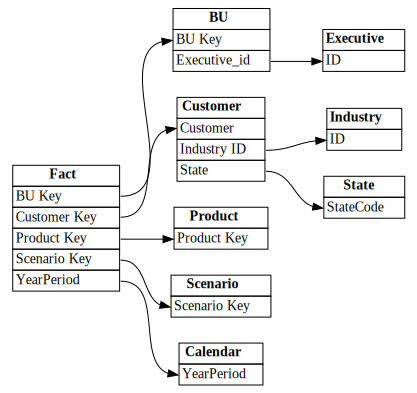

In [ ]:
plot_relationship_metadata(relationships)

This graph shows the "ground truth" for relationships between tables in this dataset, as it reflects how they were defined in Power BI by a subject matter expert.

## Complement relationships discovery

If you started with relationships that were auto-detected by Power BI, you'd have a smaller set:

StatementMeta(, add07076-dc47-4e48-9a33-4fbb21f1bcea, 15, Finished, Available)

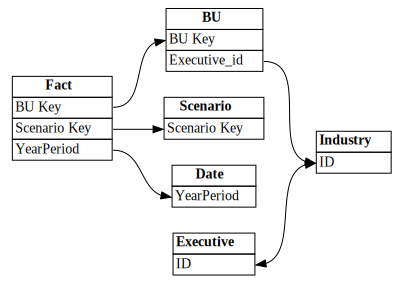

In [ ]:
dataset = "Customer Profitability Sample (auto)"
autodetected = fabric.list_relationships(dataset)
plot_relationship_metadata(autodetected)

Notice that Power BI's auto-detection missed many relationships. Moreover, two of the auto-detected relationships are semantically incorrect:

* `Executive[ID]` -> `Industry[ID]`
* `BU[Executive_id]` -> `Industry[ID]`

Discard the incorrectly identified relationships. But first, print out the relationships as a table:

In [ ]:
autodetected

StatementMeta(, add07076-dc47-4e48-9a33-4fbb21f1bcea, 16, Finished, Available)

,Multiplicity,From Table,From Column,To Table,To Column
0,m:1,Fact,BU Key,BU,BU Key
1,m:1,Fact,Scenario Key,Scenario,Scenario Key
2,m:1,Fact,YearPeriod,Date,YearPeriod
3,1:1,Executive,ID,Industry,ID
4,m:1,BU,Executive_id,Industry,ID


Incorrect relationships to the `Industry` table appear in rows with index 3 and 4. Use this information to remove these rows.

In [ ]:
autodetected.drop(index=[3,4], inplace=True)
autodetected

StatementMeta(, add07076-dc47-4e48-9a33-4fbb21f1bcea, 17, Finished, Available)

,Multiplicity,From Table,From Column,To Table,To Column
0,m:1,Fact,BU Key,BU,BU Key
1,m:1,Fact,Scenario Key,Scenario,Scenario Key
2,m:1,Fact,YearPeriod,Date,YearPeriod


Now you have correct, but incomplete relationships, as shown in the following visualization using `plot_relationship_metadata`:

StatementMeta(, add07076-dc47-4e48-9a33-4fbb21f1bcea, 18, Finished, Available)

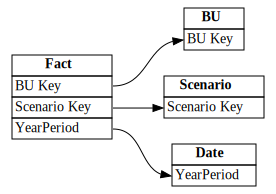

In [ ]:
plot_relationship_metadata(autodetected)

Load all the tables from the dataset, using SemPy's `list_tables` and `read_table` functions:

In [ ]:
tables = {table: fabric.read_table(dataset, table) for table in fabric.list_tables(dataset)['Name']}

tables.keys()

StatementMeta(, add07076-dc47-4e48-9a33-4fbb21f1bcea, 19, Finished, Available)

dict_keys(['Fact', 'BU', 'Date', 'Scenario', 'Product', 'Customer', 'Industry', 'Executive', 'State'])

Find relationships between tables, using `find_relationships`, and review the log output to get some insights into how this function works:

In [ ]:
suggested_relationships_all = find_relationships(
    tables,
    name_similarity_threshold=0.7,
    coverage_threshold=0.7,
    verbose=2
)

StatementMeta(, add07076-dc47-4e48-9a33-4fbb21f1bcea, 20, Finished, Available)

Searching for relationships between tables Fact and BU
  Columns BU Key and BU Key
  Columns BU Key and BU
    Detected BU Key->BU Key coverage: (1.0, 0.15853658536585366)
Searching for relationships between tables Fact and Date
  Columns YearPeriod and YearPeriod
  Columns YearPeriod and Period
    Detected YearPeriod->YearPeriod coverage: (1.0, 0.19047619047619047)
Searching for relationships between tables Fact and Scenario
  Columns Scenario Key and Scenario Key
  Columns Scenario Key and Scenario
    Detected Scenario Key->Scenario Key coverage: (1.0, 1.0)
Searching for relationships between tables Fact and Product
  Columns Product Key and Product Key
  Columns Product Key and Product
    Detected Product Key->Product Key coverage: (0.8571428571428571, 1.0)
Searching for relationships between tables Fact and Customer
  Columns Customer Key and Customer
  Columns Customer Key and Name
    Detected Customer Key->Customer coverage: (0.7666666666666667, 0.21100917431192662)
Searching

Visualize newly discovered relationships:

StatementMeta(, add07076-dc47-4e48-9a33-4fbb21f1bcea, 21, Finished, Available)

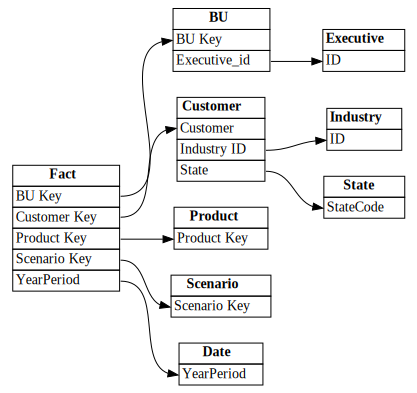

In [ ]:
plot_relationship_metadata(suggested_relationships_all)

SemPy was able to detect all relationships! To limit the search to additional relationships that weren't identified previously, use the `exclude` parameter:

In [ ]:
additional_relationships = find_relationships(
    tables,
    exclude=autodetected,
    name_similarity_threshold=0.7,
    coverage_threshold=0.7
)

additional_relationships

StatementMeta(, add07076-dc47-4e48-9a33-4fbb21f1bcea, 22, Finished, Available)

,Multiplicity,From Table,From Column,To Table,To Column,Coverage From,Coverage To,Null Count From,Null Count To,Unique Count From,Unique Count To,Row Count From,Row Count To
0,m:1,Fact,Product Key,Product,Product Key,0.857143,1.000000,0,0,7,6,47646,6
1,m:1,Fact,Customer Key,Customer,Customer,0.766667,0.211009,0,0,90,327,47646,327
2,m:1,BU,Executive_id,Executive,ID,1.000000,0.888889,0,0,8,9,164,9
3,m:1,Customer,Industry ID,Industry,ID,0.968750,0.911765,0,0,32,34,327,34
4,m:1,Customer,State,State,StateCode,0.891892,0.647059,0,0,37,51,327,51


## Validate the relationships

To validate the relationships, you need to load the data from the _Customer Profitability Sample_ dataset first:

In [ ]:
dataset = "Customer Profitability Sample"
tables = {table: fabric.read_table(dataset, table) for table in fabric.list_tables(dataset)['Name']}

tables.keys()

StatementMeta(, add07076-dc47-4e48-9a33-4fbb21f1bcea, 23, Finished, Available)

dict_keys(['Fact', 'BU', 'Calendar', 'Scenario', 'Product', 'Customer', 'Industry', 'Executive', 'State'])

Once you have the data, you can check for overlap of primary and foreign key values by using the `list_relationship_violations` function. Supply the output of the `list_relationships` function as input to `list_relationship_violations`:

In [ ]:
list_relationship_violations(tables, fabric.list_relationships(dataset))

StatementMeta(, add07076-dc47-4e48-9a33-4fbb21f1bcea, 24, Finished, Available)

,Multiplicity,From Table,From Column,To Table,To Column,Type,Message
0,m:1,Fact,Customer Key,Customer,Customer,partial join,"21 out of 90 values in Fact[Customer Key] not present in Customer[Customer]: 1042,1044,1045,1024,1002,1000,1010,1032,1017,1025,..."
1,m:1,Fact,Product Key,Product,Product Key,partial join,1 out of 7 values in Fact[Product Key] not present in Product[Product Key]: 50
2,m:1,Customer,State,State,StateCode,partial join,"4 out of 37 values in Customer[State] not present in State[StateCode]: ON,MX,MB,NSW"
3,m:1,Customer,Industry ID,Industry,ID,partial join,1 out of 32 values in Customer[Industry ID] not present in Industry[ID]: 31


The relationship violations provide some interesting insights. For example, you see that one out of seven values in `Fact[Product Key]` is not present in `Product[Product Key]`, and this missing key is `50`.

Exploratory data analysis is an exciting process, and so is data cleaning. There's always something that the data is hiding, depending on how you look at it, what you want to ask, and so on. Semantic Link provides you with new tools that you can use to achieve more with your data. 

## Related content

Check out other tutorials for Semantic Link / SemPy:
1. Clean data with functional dependencies
1. Analyze functional dependencies in a Power BI sample dataset
1. Discover relationships in the _Synthea_ dataset using Semantic Link
1. Extract and calculate Power BI measures from a Jupyter Notebook